<a href="https://colab.research.google.com/github/olesok87/Miniproject2_CDR_hallucination/blob/master/CDR_hallucination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CDR redesign in a complex

Project goal: change CDR sequences in one of my published structures

structure: 6Y6C TREM2 with scFv-4

Improve binding and change stability of complex and the protein





# Annotate the CDRs here:

https://www.novoprolabs.com/tools/cdr

 -CDR-L2  52-67 (50-56)

 -CDR-H1 33-37 (31 -35)
 169-173 (31-35 kabat, 138aa had to be added to make my sequence annotated correctly*)

 -CDR-H2 188-203 (50-65)

 -CDR-H3 233-240 (95-102)


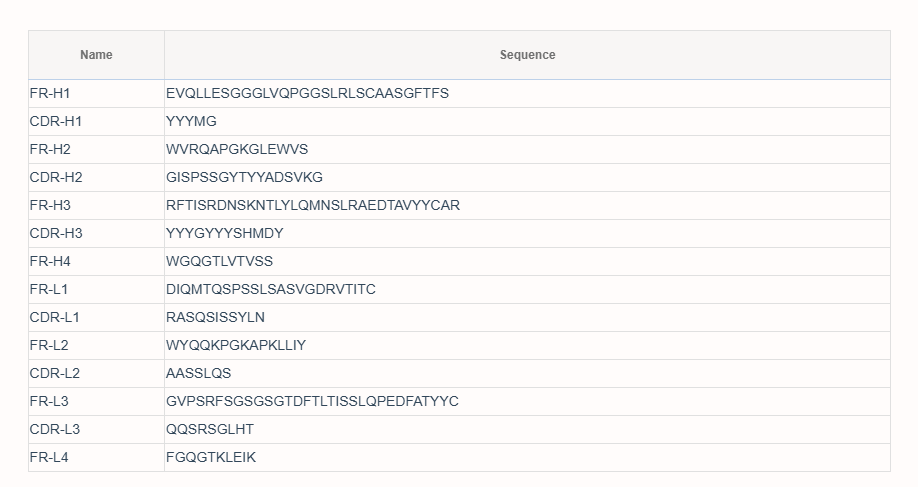




* Note, I could not find any truly good tools to do this task so Im making mental note to try to develop something or test more obscure things



# Strategy 1 — Sequence-only design (fixed backbone)

Geometry of the complex will remain fixed, only the CDRs involved in current structure will be changed.

RF diffusion will create new geometry in the CDRs which will later be filled by protein MPNN and modelled by Alphafold. 10 models will be created by RF diffusion and 5 models will be generated by protein MPNN giving final 50 models (this is not a huge amount but I want to reduce Alphafold run time and Rosetta FlexDDG).

Alphafold will fold the structures and Rosetta FlexDDG will asses energy.

A very nice tool called RFAntibody has been created by Baker lab (https://github.com/RosettaCommons/RFantibody). However it's more suitable for de novo design and requires local installation with NVIDIA GPU which I don't have

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Run RF diffusion on  Relevant CDRs

-  CDR-H1-H3 and CDR-L2 (based on the pdb)

Run:
https://colab.research.google.com/github/sokrypton/ColabDesign/blob/main/rf/examples/diffusion.ipynb

Settings

iteration 25 (reduction for time's sake)
num of designs 8

contigs='B:C1-32/4-6/C38-51/16-18/C69-100/10-14/C113-187/6-8/C195-300

Confirmation of correct CDR placment in Design 01

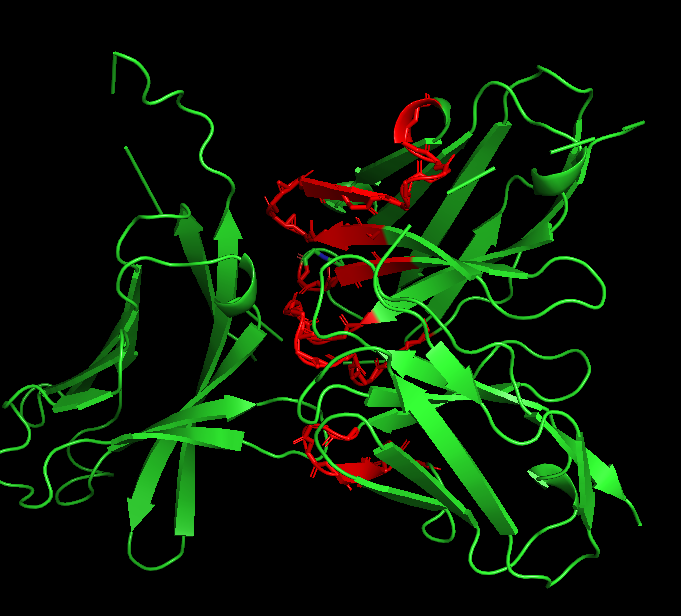

# Run Protein MPNN on  8 designs (0-7)


Run:
https://colab.research.google.com/github/sokrypton/ColabDesign/blob/main/rf/examples/diffusion.ipynb

Settings:
Designs 4

sampling temp 0.1

rm_aa : C (do not use cysteins)

initial guess : true

num of cycles : 3

use AlphaFold Multimer : True



Saved ranked CSV to /content/drive/MyDrive/Miniproject2/Strategy1/output/ranked_designs.csv

Top 5 ranked designs:

display_name  rank  d  n     mpnn    plddt      ptm      pae     rmsd                                                                                                                                                                                                                                                                                                                                                            seq  composite_score
  1 |d.1 n.1     1  1  1 1.008643 0.815847 0.642181 5.007653 5.256841 NTTVFQGVAGQSLQVSCPYDSMKHWGRRKAWCRQLGEKGPCQRVVSTHNLWLLSFLRRWNGSTAITDDTLGGTLTITLRNLQPHDAGLYQCQSLHGSEADTLRKVLVEVLADPLDHRD/EVQLLESGGGLVQPGGSLRLSCAASGFTFSQASFSWVRQAPGKGLEWVSSISANGNYVTVAPRYAGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARHDIGGGWNERVTSHWGQGTLVTVSSDIQMTQSPSSLSASVGDRVTITCRASQSISSYLNWYQQKPGKAPKLLIYNGGGSLAPGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQSRSGLHTFGQGTKLEIK         0.895271
  2 |d.1

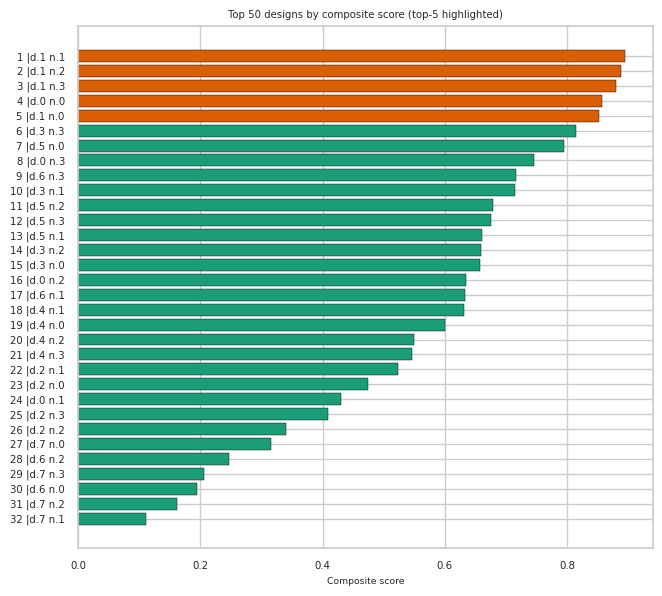

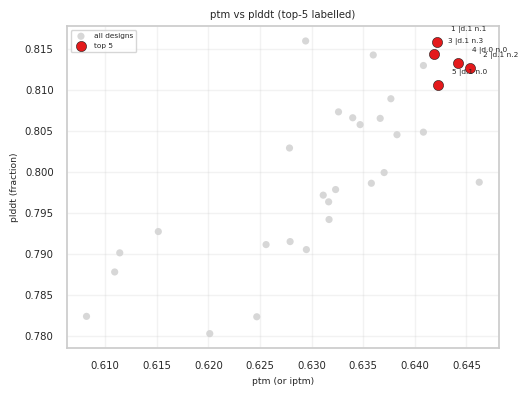

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# score results according to the weights - 40% ipTM, 25% mean CDR pLDDT, 20% (−) interface PAE, 10% MPNN score, 5% (−) interface RMSD.

# Colab-ready ranking + visualization script
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# === User config ===
INPUT_CSV = "/content/drive/MyDrive/Miniproject2/Strategy1/output/mpnn_results.csv"        # change to your uploaded filename
OUTPUT_CSV = "/content/drive/MyDrive/Miniproject2/Strategy1/output/ranked_designs.csv"
WEIGHTS = {
    "ptm": 0.40,
    "plddt": 0.25,
    "pae": 0.20,
    "mpnn": 0.10,
    "rmsd": 0.05
}
PLOT_TOP_N = 50  # how many designs to show in bar chart

# Scaling: reduce sizes to 2/3 (smaller by 1/3)
SCALE = 2.0/3.0
BASE_BAR_FIG = (10, max(4, PLOT_TOP_N * 0.18))   # original base
BAR_FIGSIZE = (BASE_BAR_FIG[0]*SCALE, BASE_BAR_FIG[1]*SCALE)
SCATTER_FIGSIZE = (8*SCALE, 6*SCALE)
BASE_FONTSCALE = 1.0
FONTSCALE = BASE_FONTSCALE * SCALE
ALL_MARKER_SIZE = 40 * SCALE
TOP5_MARKER_SIZE = 80 * SCALE
TEXT_OFFSET = 0.002 * SCALE

# === Helpers ===
def robust_normalize(series, higher_is_better=True, clip_percentile=(1,99)):
    s = series.dropna()
    if s.size == 0:
        return pd.Series(0.5, index=series.index)
    lo, hi = np.nanpercentile(s, clip_percentile)
    clipped = series.clip(lo, hi)
    if clipped.max() == clipped.min():
        return pd.Series(0.5, index=series.index)
    norm = (clipped - clipped.min()) / (clipped.max() - clipped.min())
    return norm if higher_is_better else (1.0 - norm)

def ensure_plddt_fraction(series):
    s = series.astype(float)
    return s / 100.0 if s.max() > 2.0 else s

# === Load ===
df = pd.read_csv(INPUT_CSV)
required = {"design","n","mpnn","plddt","ptm","pae","rmsd","seq"}
if not required.issubset(set(df.columns)):
    missing = required - set(df.columns)
    raise ValueError(f"Input CSV missing required columns: {missing}")

df = df.copy()
df["plddt"] = ensure_plddt_fraction(df["plddt"])
for c in ["mpnn","plddt","ptm","pae","rmsd"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# === Normalize ===
df["_ptm_norm"]   = robust_normalize(df["ptm"],   higher_is_better=True)
df["_plddt_norm"] = robust_normalize(df["plddt"], higher_is_better=True)
df["_mpnn_norm"]  = robust_normalize(df["mpnn"],  higher_is_better=True)
df["_pae_norm"]   = robust_normalize(df["pae"],   higher_is_better=False)
df["_rmsd_norm"]  = robust_normalize(df["rmsd"],  higher_is_better=False)

# === Composite score ===
df["composite_score"] = (
    WEIGHTS["ptm"]   * df["_ptm_norm"] +
    WEIGHTS["plddt"] * df["_plddt_norm"] +
    WEIGHTS["pae"]   * df["_pae_norm"] +
    WEIGHTS["mpnn"]  * df["_mpnn_norm"] +
    WEIGHTS["rmsd"]  * df["_rmsd_norm"]
)

# Sort and rank
df = df.sort_values(by=["composite_score","ptm","plddt"], ascending=[False,False,False]).reset_index(drop=True)
df["rank"] = np.arange(1, len(df)+1)

# Create display name column formatted as "rank |d.<design> n.<n>"
def make_display_name(row):
    try:
        d = int(row["design"])
    except Exception:
        d = row["design"]
    try:
        n = int(row["n"])
    except Exception:
        n = row["n"]
    return f"{int(row['rank'])} |d.{d} n.{n}"

df["display_name"] = df.apply(make_display_name, axis=1)

# Prepare output: rename design -> d for output and include display_name as first column
out_df = df.rename(columns={"design": "d"})
out_cols = ["display_name","rank","d","n","mpnn","plddt","ptm","pae","rmsd","seq","composite_score"]
out_df = out_df[out_cols]
out_df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved ranked CSV to {OUTPUT_CSV}\n")
print("Top 5 ranked designs:\n")
print(out_df.head(5).to_string(index=False))

# === Visualization (smaller and cleaner) ===
sns.set(style="whitegrid", context="notebook", font_scale=FONTSCALE)

# Bar chart: top N composite scores, highlight top-5, labels use display_name
topn = df.head(PLOT_TOP_N).copy()
plt.figure(figsize=BAR_FIGSIZE)
y_labels = topn["display_name"].tolist()
colors = ["#d95f02" if r<=5 else "#1b9e77" for r in topn["rank"]]
bars = plt.barh(y_labels, topn["composite_score"], color=colors, edgecolor="black", linewidth=0.3)
plt.gca().invert_yaxis()
plt.xlabel("Composite score", fontsize=10*FONTSCALE)
plt.title(f"Top {PLOT_TOP_N} designs by composite score (top-5 highlighted)", fontsize=11*FONTSCALE)
plt.tight_layout()
plt.show()

# Scatter: ptm vs plddt for all, label top5 with display_name
plt.figure(figsize=SCATTER_FIGSIZE)
plt.scatter(df["ptm"], df["plddt"], c="lightgray", s=ALL_MARKER_SIZE, label="all designs", alpha=0.9, edgecolors="none")
top5 = df.head(5)
plt.scatter(top5["ptm"], top5["plddt"], c="#e41a1c", s=TOP5_MARKER_SIZE, label="top 5", edgecolor="k", linewidth=0.4)
for _, row in top5.iterrows():
    plt.text(row["ptm"]+TEXT_OFFSET, row["plddt"]+TEXT_OFFSET, row["display_name"], fontsize=8*FONTSCALE)
plt.xlabel("ptm (or iptm)", fontsize=10*FONTSCALE)
plt.ylabel("plddt (fraction)", fontsize=10*FONTSCALE)
plt.title("ptm vs plddt (top-5 labelled)", fontsize=11*FONTSCALE)
plt.legend(frameon=True, fontsize=8*FONTSCALE)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Offer download
try:
    files.download(OUTPUT_CSV)
except Exception:
    pass



## Results

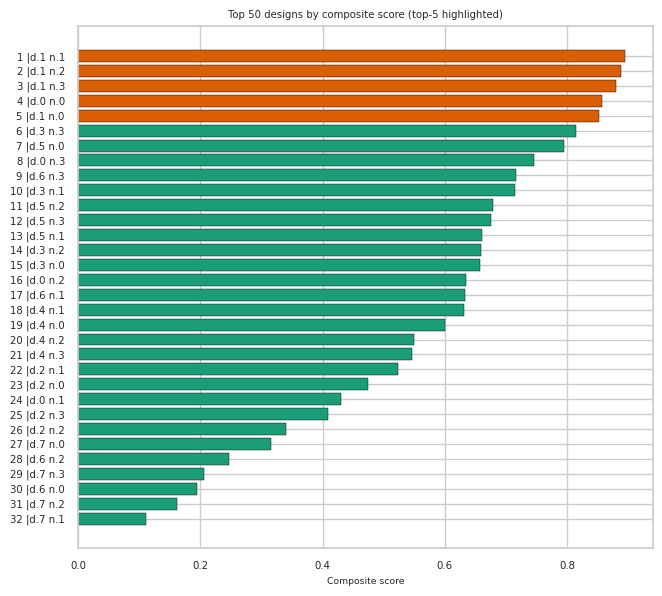

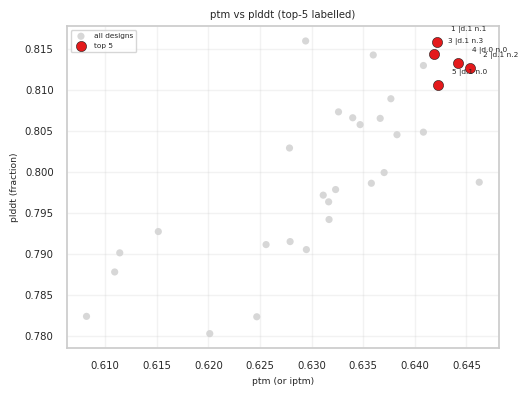




## Next steps

1. Relax structure by Amber


2. Analyse interaction strength
- Pisa in CCP4 (scripts to analyse data in https://github.com/olesok87/Miniproject2_CDR_hallucination)
- InterfaceAnalyzer in Rosetta (after RosettaRelax) (scriprt to analyse data in https://github.com/olesok87/Miniproject2_CDR_hallucination)

- PRODIGY (https://rascar.science.uu.nl/prodigy/run/40nNuvXJ) interface analyzer


3. Analyze biophysical propensities (So far this needs development as I need ability to batch submit):
Developability Analyzer (https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabpred)
- Solubility Analyzer (https://www-cohsoftware.ch.cam.ac.uk/index.php/camsolstrucorr)
- Aggregation Propensity (https://biocomp.chem.uw.edu.pl/A3D2)